In [1]:
import sys

if sys.platform == "win32":
    sys.path.append("D:/DevSpace/Projects/Research/SeizureDetection")
elif sys.platform == "linux":
    sys.path.append("/mnt/d/gniazdko/SeizureDetection")

In [2]:
from core.machine_learning.engine import SimpleNet, BCEWithLogitsLoss, BinaryAccuracy, SGD, StepLR

d:\DevSpace\Projects\Research\research_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from torchsummary import summary
import matplotlib.pyplot as plt

from core.utils import ProjectManager, ConfigManager
from core.utils import load_model_input_data

from core.machine_learning import (
    sample_data,
    split_data_by_proportions,
    create_dataloaders,
)

In [4]:
project_manager = ProjectManager()
configs_directory_path = project_manager.get_configs_directory_path()
primary_data_path = project_manager.get_primary_data_path()
model_directory_path = project_manager.get_model_data_path()

config_manager = ConfigManager(configs_directory_path)
model_params = config_manager.load_config("parameters_machine_learning")

In [5]:
model_input_data = load_model_input_data(
    primary_data_path, model_params["data_version"])

In [6]:
model_input_data = sample_data(model_input_data, fraction=1)

In [7]:
X, y = model_input_data

X.shape, y.shape

((2321, 18, 64, 64, 1), (2321,))

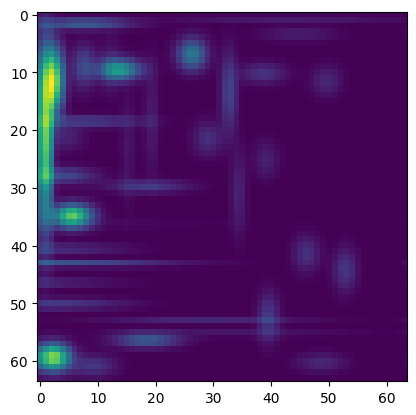

In [9]:
plt.imshow(X[2137, 11, :, :]);

In [10]:
data_splits = split_data_by_proportions(
    model_input_data, model_params["data_parameters"])

train_data, valid_data, test_data = create_dataloaders(
    data_splits, model_params["data_parameters"])

In [11]:
single_batch = next(iter(train_data))


features, targets = single_batch
features, targets = features.to('cuda'), targets.to('cuda')

features.shape, targets.shape

(torch.Size([64, 1, 18, 64, 64]), torch.Size([64]))

In [12]:
model_parameters = model_params["model_parameters"]

In [13]:
model = SimpleNet(
    in_channels=model_parameters["in_channels"],
    num_classes=model_parameters["num_classes"],
    dropout=model_parameters["dropout"])

model = model.to(model_parameters["device"])

In [14]:
model

SimpleNet(
  (conv_net): Sequential(
    (0): Conv2Plus1D(
      (spatial_convolution): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temporal_convolution): Conv1d(7, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2Plus1D(
      (spatial_convolution): Conv2d(16, 57, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temporal_convolution): Conv1d(57, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2Plus1D(
      (spatial_convolution): Conv2d(32, 115, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
summary(model, input_data=(1, 18, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 16, 16]       --
|    └─Conv2Plus1D: 2-1                  [-1, 16, 18, 128, 128]    --
|    |    └─Conv2d: 3-1                  [-1, 7, 128, 128]         70
|    |    └─Conv1d: 3-2                  [-1, 16, 18]              352
|    └─BatchNorm3d: 2-2                  [-1, 16, 18, 128, 128]    32
|    └─ReLU: 2-3                         [-1, 16, 18, 128, 128]    --
|    └─MaxPool3d: 2-4                    [-1, 16, 9, 64, 64]       --
|    └─Conv2Plus1D: 2-5                  [-1, 32, 9, 64, 64]       --
|    |    └─Conv2d: 3-3                  [-1, 57, 64, 64]          8,265
|    |    └─Conv1d: 3-4                  [-1, 32, 9]               5,504
|    └─BatchNorm3d: 2-6                  [-1, 32, 9, 64, 64]       64
|    └─ReLU: 2-7                         [-1, 32, 9, 64, 64]       --
|    └─MaxPool3d: 2-8                    [-1, 32, 4, 32, 32]       --
|    └─C

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 16, 16]       --
|    └─Conv2Plus1D: 2-1                  [-1, 16, 18, 128, 128]    --
|    |    └─Conv2d: 3-1                  [-1, 7, 128, 128]         70
|    |    └─Conv1d: 3-2                  [-1, 16, 18]              352
|    └─BatchNorm3d: 2-2                  [-1, 16, 18, 128, 128]    32
|    └─ReLU: 2-3                         [-1, 16, 18, 128, 128]    --
|    └─MaxPool3d: 2-4                    [-1, 16, 9, 64, 64]       --
|    └─Conv2Plus1D: 2-5                  [-1, 32, 9, 64, 64]       --
|    |    └─Conv2d: 3-3                  [-1, 57, 64, 64]          8,265
|    |    └─Conv1d: 3-4                  [-1, 32, 9]               5,504
|    └─BatchNorm3d: 2-6                  [-1, 32, 9, 64, 64]       64
|    └─ReLU: 2-7                         [-1, 32, 9, 64, 64]       --
|    └─MaxPool3d: 2-8                    [-1, 32, 4, 32, 32]       --
|    └─C

In [16]:
loss_fn = BCEWithLogitsLoss()
accuracy_fn = BinaryAccuracy()

optimizer = SGD(
    params=model.parameters(),
    lr=model_parameters["learning_rate"],
    weight_decay=model_parameters["weight_decay"])
    
lr_scheduler = StepLR(
    optimizer,
    step_size=model_parameters["step_size"],
    gamma=model_parameters["gamma"])

In [18]:
output = model(features)
output

tensor([[-0.0941, -0.2015],
        [ 0.0102, -0.3050],
        [-0.1143, -0.3359],
        [-0.0169, -0.1669],
        [-0.0565, -0.3003],
        [-0.0215, -0.3397],
        [-0.1484, -0.2690],
        [ 0.0054, -0.1211],
        [ 0.0107, -0.1467],
        [-0.0292, -0.3553],
        [-0.1121, -0.2732],
        [-0.2011, -0.3425],
        [ 0.0038, -0.2056],
        [-0.0495, -0.2830],
        [ 0.0411, -0.1861],
        [-0.0273, -0.2350],
        [ 0.0793, -0.1201],
        [-0.0562, -0.1731],
        [ 0.0335, -0.2016],
        [-0.0151, -0.2897],
        [-0.0724, -0.1502],
        [-0.0655, -0.4070],
        [-0.0233, -0.2505],
        [-0.0760, -0.2207],
        [-0.0503, -0.2108],
        [ 0.0544, -0.1662],
        [-0.0460, -0.1209],
        [-0.0547, -0.3427],
        [ 0.0073, -0.2724],
        [ 0.0310, -0.3057],
        [-0.0081, -0.2605],
        [ 0.0534, -0.2413],
        [-0.0987, -0.2512],
        [-0.0062, -0.2693],
        [-0.0012, -0.1262],
        [-0.0051, -0

In [19]:
from torch.nn import CrossEntropyLoss

In [20]:
import torch

In [21]:
targets[:5]

tensor([0, 1, 0, 1, 0], device='cuda:0')

In [33]:
targets[:5]

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]], device='cuda:0')

In [32]:
torch.argmax(targets[:5], dim=1)

tensor([1, 1, 1, 0, 0], device='cuda:0')

In [22]:
targets.shape, output.shape

(torch.Size([64]), torch.Size([64, 2]))

In [23]:
loss_fn = CrossEntropyLoss()

In [26]:
loss_fn(output, targets)

tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward0>)

In [25]:
print("Typ output:", output.dtype)  # Powinno być torch.float32 lub torch.float64
print("Typ targets:", targets.dtype)  # Powinno być torch.int64 (long)

Typ output: torch.float32
Typ targets: torch.int64
